In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Setup paths
base_path = '/content/LS_ML/Week4'
POS_PATH = os.path.join(base_path,'data', 'positive')
NEG_PATH = os.path.join(base_path,'data', 'negative')
ANC_PATH = os.path.join(base_path,'data', 'anchor')

In [ ]:
!git clone https://github.com/kingmk-3/LS_ML.git

fatal: destination path 'LS_ML' already exists and is not an empty directory.


In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(400)

In [ ]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding=tf.convert_to_tensor(input_embedding)
        validation_embedding=tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)


In [ ]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

#////////
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/LS_ML/Week4/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        yhat=tf.reshape(yhat, (16,), name=None)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [ ]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step

 Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step

 Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step

 Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step

 Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step

 Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step

 Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step

 Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step

 Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step

 Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step

 Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step

 Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step

 Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step

 Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step

 Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step

 Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step

 Ep

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


In [ ]:
[1 if i > 0.5 else 0 for i in tf.reshape(y_hat,(16,))]

[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]

In [ ]:
y_true

array([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

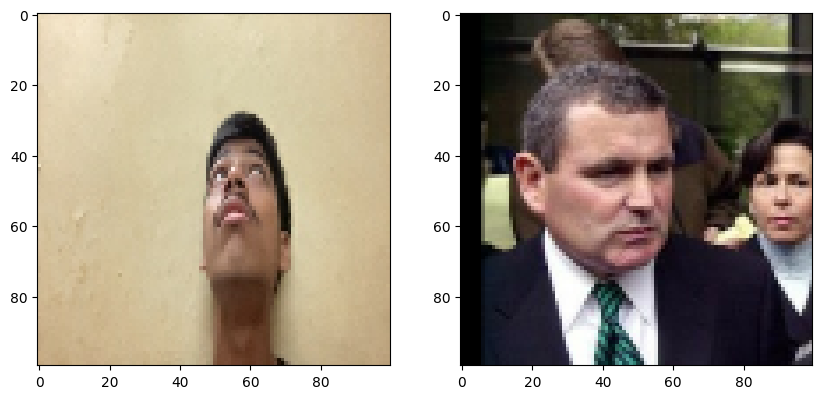

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


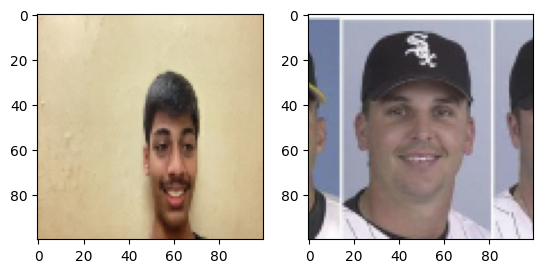

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


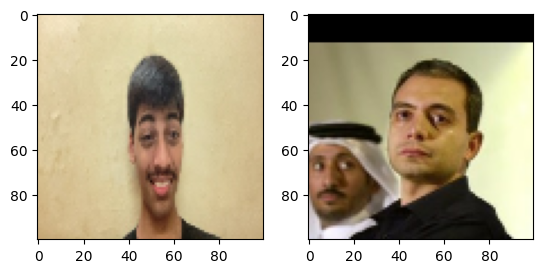

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


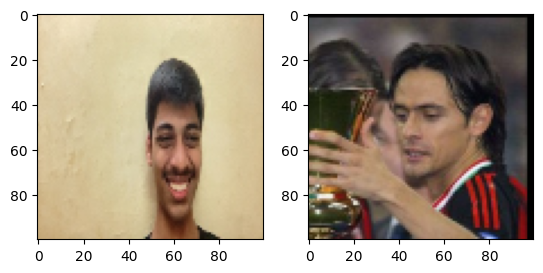

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


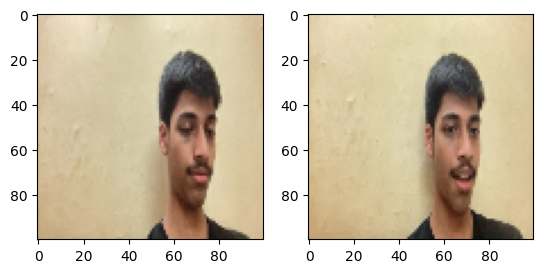

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


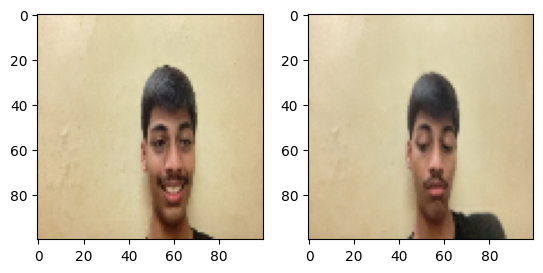

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


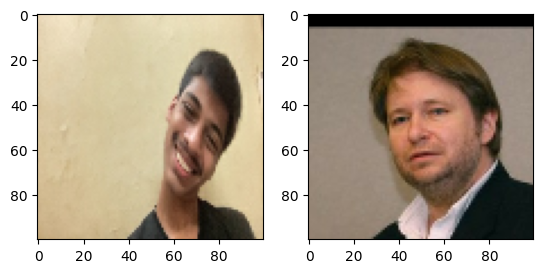

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


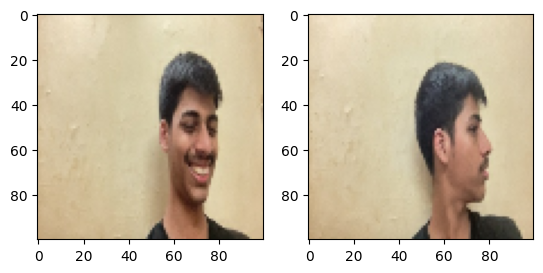

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


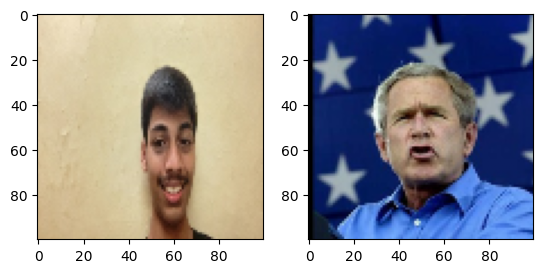

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


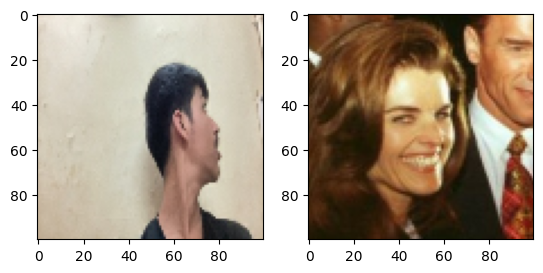

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


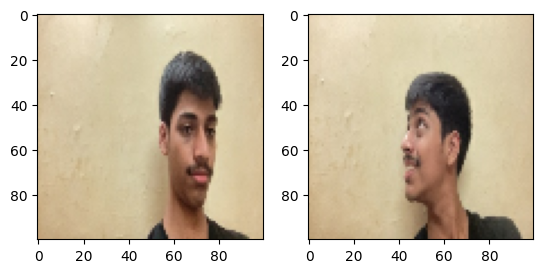

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


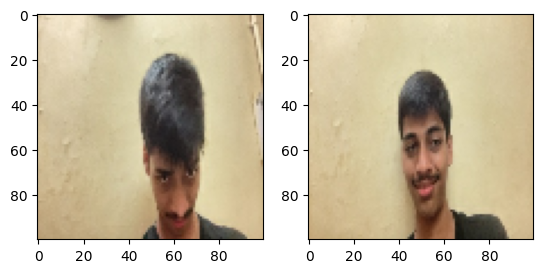

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


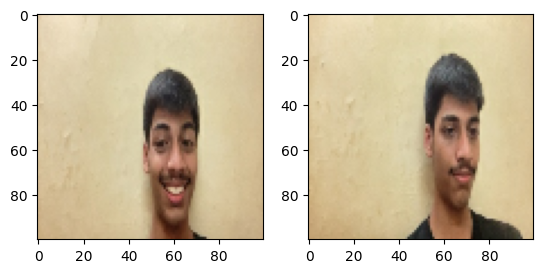

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


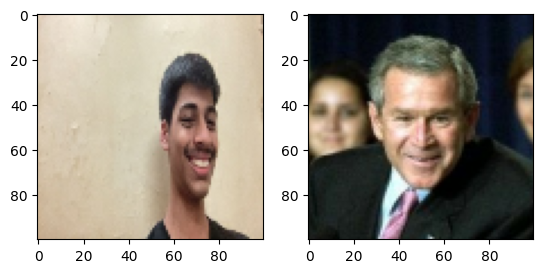

-----------------------------------------------------------------------
                         Right one is some other guy, definitely not user(me)
-----------------------------------------------------------------------


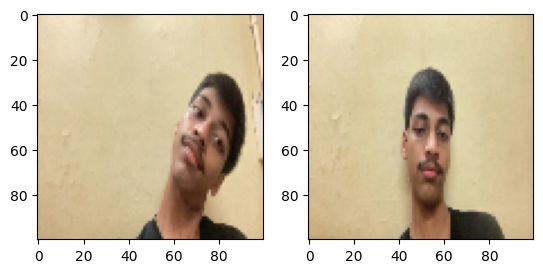

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


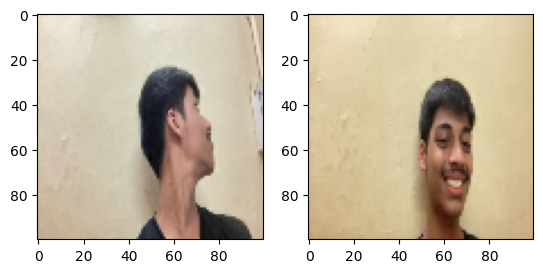

-----------------------------------------------------------------------
                                            Both are user(me)
-----------------------------------------------------------------------


In [ ]:
plt.figure(figsize=(10,8))
for i in range(16):
  plt.subplot(1,2,1)
  plt.imshow(test_input[i])

  plt.subplot(1,2,2)
  plt.imshow(test_val[i])
  plt.show()
  print("-----------------------------------------------------------------------")
  if(y_true[i]==0):
      print("                         Right one is some other guy, definitely not user(me)")
  else:
      print("                                            Both are user(me)")
  print("-----------------------------------------------------------------------")


In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print("RECALL : ",r.result().numpy(), "PRECESION : ",p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RECALL :  1.0 PRECESION :  1.0


In [ ]:
siamese_model.save('siamesemodelv2.h5')